# 3. hands-on session: **Classification problem: from *Data* to *Inference***

## **Contents**

1. Preprocess the data
1. Select features & reduce dimensions
1. Find best hyperparameters
1. Closs-validate
1. Compare classifiers
1. Combine classifiers
1. Predict

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [18]:
!pip install corner
import corner

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## **Our dataset**

SDSS data of point sources: stars vs Quasi-stellar objects

<img src="https://cdn.mos.cms.futurecdn.net/HgaCHZDNppE6e52yeDACo6-970-80.jpg.webp" height=200>

<img src="https://earthsky.org/upl/2021/01/supermassive-black-hole-artist-e1610556964639.jpg" height=200 align=right>



In [19]:
!wget -c "https://drive.google.com/uc?id=1IoQfGFo13ZP2wTyp-xvzQvguPYhE8TWB" -O "sdss_photo.csv"

--2022-10-11 18:04:49--  https://drive.google.com/uc?id=1IoQfGFo13ZP2wTyp-xvzQvguPYhE8TWB
Resolving drive.google.com (drive.google.com)... 173.194.218.102, 173.194.218.113, 173.194.218.139, ...
Connecting to drive.google.com (drive.google.com)|173.194.218.102|:443... connected.
HTTP request sent, awaiting response... 416 Requested range not satisfiable

    The file is already fully retrieved; nothing to do.



In [41]:
data = pd.read_csv("sdss_photo.csv")

## **Data preprocessing**

In [42]:
data

,u,g,r,i,z,target
0,19.240999,17.525999,16.840000,16.613001,16.492001,star
1,19.732000,18.339001,17.767000,17.580000,17.481001,star
2,16.120001,15.232000,14.933000,14.845000,14.827000,star
3,18.995001,18.150999,17.877001,17.747000,17.766001,star
4,19.032000,18.112000,17.848000,17.709999,17.712000,star
...,...,...,...,...,...,...
862,19.247000,19.047001,18.663000,18.627001,18.671000,QSO
863,26.433001,21.429001,20.261000,20.108000,20.073000,QSO
864,20.535999,20.200001,20.292999,19.910000,19.726000,QSO
865,20.627001,20.583000,20.270000,20.229000,20.190001,QSO


In [43]:
data.describe().round(2)

,u,g,r,i,z
count,867.00,867.00,867.00,867.00,867.00
mean,19.29,18.17,17.72,17.54,17.45
std,1.39,1.33,1.35,1.37,1.38
min,15.67,14.36,14.12,13.95,13.89
25%,18.50,17.29,16.74,16.54,16.45
50%,19.33,18.33,17.88,17.69,17.62
75%,20.02,19.09,18.76,18.61,18.52
max,26.43,25.17,21.14,20.72,20.91


In [44]:
sum(data.target== "star"), sum(data.target == "QSO")

(655, 212)

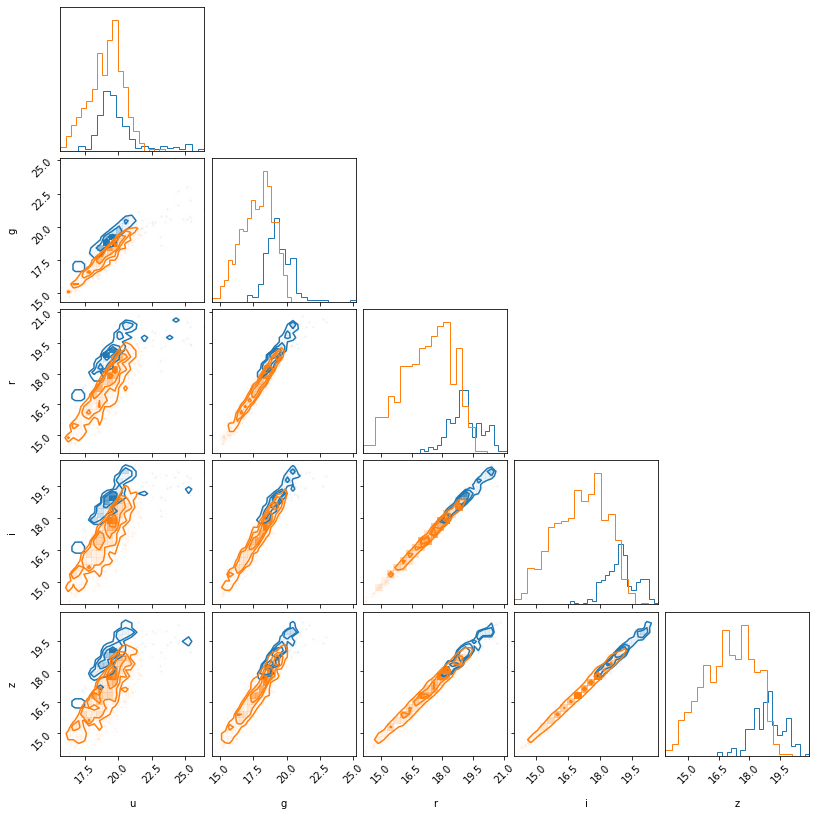

In [50]:
fig = corner.corner(X[y == 0], color="C0")
corner.corner(X[y == 1], fig=fig, color="C1");

### task 1: **create `X` and `y`**

```python
data[["u","g","r","i","z"]] -> X
data.target -> y
"QSO" -> 0
"star" -> 1
```

hint: you can use [LabelEncoder()](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html)


In [81]:
filters = ["u","g","r","i","z"]
X = data[filters]
X

,u,g,r,i,z
0,19.240999,17.525999,16.840000,16.613001,16.492001
1,19.732000,18.339001,17.767000,17.580000,17.481001
2,16.120001,15.232000,14.933000,14.845000,14.827000
3,18.995001,18.150999,17.877001,17.747000,17.766001
4,19.032000,18.112000,17.848000,17.709999,17.712000
...,...,...,...,...,...
862,19.247000,19.047001,18.663000,18.627001,18.671000
863,26.433001,21.429001,20.261000,20.108000,20.073000
864,20.535999,20.200001,20.292999,19.910000,19.726000
865,20.627001,20.583000,20.270000,20.229000,20.190001


In [82]:
y = np.array(data["target"] == "star").astype(int)
y

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [83]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
# le.fit(data.target)
# y = le.transform(data.target)
y = le.fit_transform(data.target)
y

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [84]:
le.inverse_transform([0,1])

array(['QSO', 'star'], dtype=object)

### task 2: **classify with Decision tree & test accuracy**

In [85]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

In [97]:
model = DecisionTreeClassifier()

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=420)

In [98]:
model.fit(X_train, y_train)

DecisionTreeClassifier()

In [99]:
y_pred = model.predict(X_test)
sum(y_pred == y_test) / len(y_pred)

0.9493087557603687

In [100]:
model.score(X_test, y_test)

0.9493087557603687

### task 3: **try [`classification_report`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html) and [`ConfusionMatrixDisplay`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html)**

In [101]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

In [102]:
print(classification_report(y_test, y_pred, digits=3))

              precision    recall  f1-score   support

           0      0.875     0.925     0.899        53
           1      0.975     0.957     0.966       164

    accuracy                          0.949       217
   macro avg      0.925     0.941     0.933       217
weighted avg      0.951     0.949     0.950       217



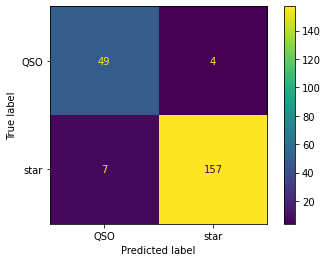

In [103]:
ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, display_labels=["QSO", "star"]);

### task 4: **rescale the data -> `X_scaled` & test score**

In [104]:
X_scaled = X.copy()
for col in X.columns:
    X_scaled[col] = (X[col] - np.mean(X[col])) / np.std(X[col])

In [105]:
X_scaled.describe().round(2)

,u,g,r,i,z
count,867.00,867.00,867.00,867.00,867.00
mean,-0.00,0.00,-0.00,-0.00,-0.00
std,1.00,1.00,1.00,1.00,1.00
min,-2.61,-2.86,-2.65,-2.62,-2.59
25%,-0.57,-0.66,-0.72,-0.73,-0.73
50%,0.03,0.12,0.12,0.11,0.12
75%,0.53,0.69,0.77,0.78,0.77
max,5.15,5.24,2.52,2.32,2.51


In [106]:
from sklearn.preprocessing import StandardScaler

X_scaled = StandardScaler().fit_transform(X)
X_scaled = pd.DataFrame(data=X_scaled, columns=X.columns)
X_scaled.describe().round(2)

,u,g,r,i,z
count,867.00,867.00,867.00,867.00,867.00
mean,-0.00,0.00,-0.00,-0.00,-0.00
std,1.00,1.00,1.00,1.00,1.00
min,-2.61,-2.86,-2.65,-2.62,-2.59
25%,-0.57,-0.66,-0.72,-0.73,-0.73
50%,0.03,0.12,0.12,0.11,0.12
75%,0.53,0.69,0.77,0.78,0.77
max,5.15,5.24,2.52,2.32,2.51


In [107]:
from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(),
                      DecisionTreeClassifier())

model.fit(X_train, y_train)

model.score(X_test, y_test)

0.9585253456221198

## **Feature selection & dimensionality reduction**

In [108]:
from sklearn.ensemble import ExtraTreesClassifier

In [109]:
clf = ExtraTreesClassifier(random_state=42).fit(X,y)
clf.feature_importances_

array([0.29715325, 0.11687197, 0.21442021, 0.19203806, 0.17951651])

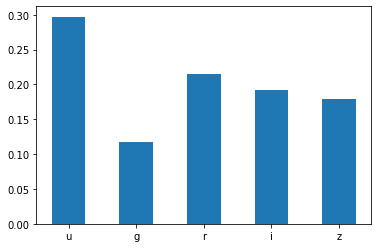

In [110]:
plt.bar(np.arange(5), clf.feature_importances_, 0.5)
plt.xticks(np.arange(5), X.columns);

#### task 5: **calculate spectral indices & test importance**



In [118]:
X["u-g"] = X.u - X.g
X["u-r"] = X.u - X.r
X["u-z"] = X.u - X.z
X["i-z"] = X.i - X.z

X

,u,g,r,i,z,u-g,u-r,u-z,i-z
0,19.240999,17.525999,16.840000,16.613001,16.492001,1.715000,2.400999,2.748999,0.121000
1,19.732000,18.339001,17.767000,17.580000,17.481001,1.393000,1.965000,2.250999,0.098999
2,16.120001,15.232000,14.933000,14.845000,14.827000,0.888000,1.187001,1.293001,0.018001
3,18.995001,18.150999,17.877001,17.747000,17.766001,0.844002,1.118000,1.229000,-0.019001
4,19.032000,18.112000,17.848000,17.709999,17.712000,0.920000,1.184000,1.320000,-0.002001
...,...,...,...,...,...,...,...,...,...
862,19.247000,19.047001,18.663000,18.627001,18.671000,0.199999,0.584000,0.576000,-0.043999
863,26.433001,21.429001,20.261000,20.108000,20.073000,5.004000,6.172001,6.360001,0.035000
864,20.535999,20.200001,20.292999,19.910000,19.726000,0.335999,0.243000,0.809999,0.184000
865,20.627001,20.583000,20.270000,20.229000,20.190001,0.044001,0.357000,0.437000,0.039000


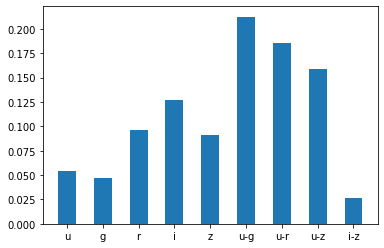

In [120]:
clf = ExtraTreesClassifier(random_state=42).fit(X,y)
plt.bar(np.arange(X.columns.size), clf.feature_importances_, 0.5)
plt.xticks(np.arange(X.columns.size), X.columns);

#### task 6: **test score if *u-r* spectral index is used**

In [123]:
X_train, X_test, y_train, y_test = train_test_split(X[["u-r"]], y, stratify=y, random_state=42)

model.fit(X_train, y_train)

model.score(X_test, y_test)

0.9354838709677419

#### task 7: **create dummy column & test importance**

In [ ]:
X_new3 = X.copy()

X_new3["dummy"] = np.random.normal(0, 1, size=len(X.r))
X_new3["dummy2"] = np.ones_like(X.r)

In [ ]:
clf = ExtraTreesClassifier().fit(X_new3,y)
plt.bar(np.arange(len(X_new3.columns)), clf.feature_importances_, 0.5)
plt.xticks(np.arange(len(X_new3.columns)), X_new3.columns);

In [ ]:
X_new3 = X.copy()

X_new3["dummy"] = np.random.normal(0, 1, size=len(X.r))
X_new3["dummy2"] = np.ones_like(X.r)

clf = ExtraTreesClassifier().fit(X_new3,y)
plt.bar(np.arange(len(X_new3.columns)), clf.feature_importances_, 0.5)
plt.xticks(np.arange(len(X_new3.columns)), X_new3.columns);

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_new3[["dummy"]], y, 
                                                    stratify=y, 
                                                    random_state=0)

model.fit(X_train, y_train)

model.score(X_test, y_test)

In [ ]:
sum(data["target"] == "star") / len(y), sum(data["target"] == "QSO") / len(y)

### **Principal component analysis**

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
X_n = pca.fit_transform(X)

In [ ]:
plt.plot(X.u, X.g, ".")
plt.plot(X_n[:,0], X_n[:,1], ".")

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_n, y, 
                                                    stratify=y, 
                                                    random_state=42)

model.fit(X_train, y_train)

model.score(X_test, y_test)

## **Tuning hyperparameters**

In [ ]:
SVC?

#### task 8: **find SVC hyperparameters with best test score**

In [ ]:
def classify(X, y, classifier):
    model = make_pipeline(StandardScaler(),
                          classifier)

    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(model.score(X_test, y_test).round(3))

In [ ]:
classify(X, y, SVC(kernel="linear"))

In [ ]:
classify(X, y, SVC(kernel="linear", C=10))

In [ ]:
classify(X, y, SVC(kernel="linear", C=0.1))

In [ ]:
classify(X, y, SVC(kernel="poly", degree=1))

In [ ]:
classify(X, y, SVC(kernel="rbf", C=100))

## **Cross-validation**

In [ ]:
from sklearn.model_selection import cross_validate

In [ ]:
model = SVC(kernel="rbf", C=1000)

res = cross_validate(model, X, y, cv=10)

np.mean(res["test_score"]), np.std(res["test_score"])

### **Grid-search + crossvalidation**

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
clf = SVC()
params = {"C" : [0.01, 0.1, 1, 10, 100],
          "kernel" : ["linear", "poly", "rbf"]}#,
          #"gamma" : ["scale", "auto"]}
model = GridSearchCV(clf, params, cv=5, n_jobs=8)
model.fit(X, y)

In [ ]:
model.cv_results_

In [ ]:
params, score = model.cv_results_["params"], model.cv_results_["mean_test_score"]

indices = np.argsort(score)

for i in indices:
    print(params[i], score[i].round(3))

In [ ]:
model.best_estimator_

## **Classifier comparison**

In [ ]:
from sklearn.neural_network import MLPClassifier # multi-layer perceptron classifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
classifiers = [MLPClassifier(max_iter=1000),
               GaussianNB(),
               DecisionTreeClassifier(),
               KNeighborsClassifier(),
               SVC(kernel="rbf", C=10)]

for classifier in classifiers:
    classify(X, y, classifier)

In [ ]:
clf = MLPClassifier(max_iter=1000)
params = {"hidden_layer_sizes" : [5, 10, 50, 100],
          "activation" : ["identity", "logistic", "tanh", "relu"],
          "solver" : ["sgd", "adam"]}
model = GridSearchCV(clf, params, cv=5, n_jobs=8)
model.fit(X, y)

In [ ]:
model.best_estimator_, model.best_score_

In [ ]:
%time MLPClassifier(hidden_layer_sizes=10, max_iter=1000, solver='sgd').fit(X_train, y_train).score(X_test, y_test)

In [ ]:
%time SVC(C=10).fit(X_train, y_train).score(X_test, y_test)

## **Ensemble methods**

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
model = RandomForestClassifier()

res = cross_validate(model, X, y, cv=10)
np.mean(res["test_score"]), np.std(res["test_score"])

In [ ]:
from sklearn.ensemble import StackingClassifier

In [ ]:
classifiers = [("MLP", MLPClassifier(max_iter=1000, random_state=42)),
               ("Bayes", GaussianNB()),
               ("RFC", RandomForestClassifier()),
               ("KNN", KNeighborsClassifier()),
               ("SVC", SVC(C=10))]

model = StackingClassifier(classifiers)

res = cross_validate(model, X, y, cv=10)
np.mean(res["test_score"]), np.std(res["test_score"])

In [ ]:
classifiers = [("MLP", MLPClassifier(max_iter=1000, random_state=42)),
               ("Bayes", GaussianNB()),
               ("DTC", DecisionTreeClassifier()),
               ("KNN", KNeighborsClassifier()),
               ("SVC", SVC(C=10))]

# train the model
clf = StackingClassifier(classifiers)

model = make_pipeline(StandardScaler(),
                      clf)

res = cross_validate(model, X, y, cv=10)
np.mean(res["test_score"]), np.std(res["test_score"])

## **Conclusion**

In [ ]:
classifiers = [("MLP", MLPClassifier(max_iter=1000, random_state=42)),
               ("Bayes", GaussianNB()),
               ("DTC", DecisionTreeClassifier()),
               ("KNN", KNeighborsClassifier()),
               ("SVC", SVC(C=10))]

# train the model
clf = StackingClassifier(classifiers)

model = make_pipeline(StandardScaler(),
                      clf)

model.fit(X_new[["u-g"]], y)

In [ ]:
u = 15.914
g = 15.500

pred = model.predict(np.array([u-g]).reshape(-1,1))

le.inverse_transform(pred)